# 04. モデリング（Modeling）

---

## 📌 TL;DR（このNotebookで分かること）

- 統合マスターデータ（47都道府県 × 公的統計）から **離職率（turnover_total）を説明する回帰モデル**を構築し、複数候補（Model A/B/C/D）を比較する  
- 評価は **説明力（Adj. R²）** と **汎化性能（LOOCV）**、および **診断（共線性・残差・影響点）** を併用し、最終モデルを選定する  
- 本Notebookの成果（最終モデル・診断結果）は、`05_interpretation.ipynb`（解釈・提言）/ `06_subgroup_analysis.ipynb`（構造分解）へ引き継ぐ  

---

## 🔎 Notebook Purpose（役割）

EDAで得た「深掘り候補」を入力として、都道府県別の離職率を説明する **回帰モデルの設計・学習・評価・診断** を行い、GitHub上で第三者が追える形で **モデル選定の根拠** を残す。

---

## 📥 Input（前提）

- 統合マスターデータ（都道府県 × 公的統計、基準年は概ね2023年）  
  `data/processed/nurse_data_clean.csv`  
  ※ 現状は探索段階のため、手動整形済みデータを使用（将来的にはETLパイプライン化して再現性を担保する）
- データ定義・クリーニング方針：`01_data_validation.ipynb` を参照  
- データ統合の生成物：`01_create_master_dataset.ipynb`（または同等の統合ノート）を前提

---

## 📤 Output（成果物）

- 候補モデル（Model A/B/C/D）の比較表（Adj. R² / LOOCV など）
- 最終採用モデル（Champion Model）の仕様（ターゲット・特徴量）
- 診断結果（多重共線性・残差・影響点）と、採用判断の根拠

---

## 🧭 Analytical Design（分析設計）

1. **モデル候補の構築（A/B/C）**  
   仮説に基づき特徴量を追加し、説明力と安定性の変化を比較する  
2. **係数の確認（最小限）**  
   方向性（+/-）と有意性を確認し、過剰適合や不自然な符号を検知する  
3. **診断**  
   - 共線性（VIF）  
   - 残差（線形性・等分散・正規性の崩れ）  
   - 影響点（Cook’s distance）  
4. **汎化性能の比較（LOOCV）**  
   サンプル数（47）を踏まえ、学習データ内での過大評価を抑える  
5. **最終モデル選定（Model D）**  
   「汎化性能」を優先しつつ、解釈可能性と実務的妥当性も加味して決定する  

---

## ⚠ Notes（読み手への注意）

- 本分析は **因果推論ではない**（47都道府県の集計データにおける関連の整理）  
- 推定はデータ定義・年次差・未観測要因の影響を受けうるため、解釈は `05_interpretation.ipynb` で慎重に行う  


In [1]:
# ---------------------------------------------------------
# 1. 分析の準備（ライブラリとデータの読み込み）
# ---------------------------------------------------------

# データ加工（ETL）と行列演算のための標準ライブラリをインポート
import pandas as pd
import numpy as np

# 統計的な傾向を可視化（Data Visualization）するための描画のエンジンをロード
import matplotlib.pyplot as plt
import seaborn as sns

#OSに依存しないパス操作（Filesystem Path Handling）を可能にするモジュール
from pathlib import Path

# Jupyter環境での出力（DataFrameの表示など）を制御
from IPython.display import display

# 統計的推論（Inference）や回帰分析を行うための統計モデルライブラリ
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 多重共線性（Multicollinearity）を診断するための指標（VIF）をロード
from statsmodels.stats.outliers_influence import variance_inflation_factor

# モデルの汎化性能を評価するための検証戦略（Validation Strategy）をロード
from sklearn.model_selection import LeaveOneOut, cross_val_score

# 機械学習（ML）のベースラインとなる線形回帰アルゴリズム
from sklearn.linear_model import LinearRegression

# 可視化におけるフォントのローカライゼーション（日本語表示対応）を実行
import japanize_matplotlib

# グラフのグローバルなスタイル設定とタイポグラフィの定義
sns.set_theme(style="whitegrid",font="Hiragino Sans")
plt.rcParams["figure.figsize"] = (10,6)

# データソース（Data Ingestion Source）のパスを定義
DATA_PATH = Path("../data/processed/nurse_data_clean.csv")

# 構造化データ（CSV）をメモリ上のDataFrameオブジェクトに展開
df = pd.read_csv(DATA_PATH)

# 取り込んだデータの「レコード数」と「特徴量数」を確認する整合性をチェック
print("Loaded:",df.shape)

Loaded: (47, 23)


In [2]:
# ---------------------------------------------------------
# 2. モデリング設定（ターゲット・候補変数）
# ---------------------------------------------------------

# 予測・分析の対象となる「目的変数（Label）」を定義
target = "turnover_total"

# ドメイン知識に基づき、段階的に複雑度を上げた「特徴量セット（Feature Sets）」を設計
model_A = ["rent_private","home_ownership_rate"]     #ベースライン生活環境要因
model_B = ["rent_private","home_ownership_rate","night_shift_72h_plus"] # 拡張１：労働負荷要因を追加
model_C = ["rent_private","home_ownership_rate","night_shift_72h_plus", "job_openings_ratio"] # 拡張２：市場流動性要因を追加

# 複数のモデル候補を反復処理（Iteration）可能な形式で管理
models = {
    "Model_A": model_A,
    "Model_B": model_B,
    "Model_C": model_C
}

# 実行前に全モデルで必要なカラムを網羅した「スキーマバリデーション」用リストを生成
need_cols = [target] + sorted({c for cols in models.values() for c in cols})

# 物理的なカラムの存在確認を行い、データ欠落による実行時のエラーを未然に防止
missing = [c for c in need_cols if c not in df.columns]
if missing:
    # 期待するデータが存在しない場合に処理を明示的に中断させる「例外処理（Exception Handling）」
    raise ValueError(f"Missing columns in df:{missing}")

# 分析に必要なカラムのみを抽出し、ユニークなサブセットとして保持
use_cols = [target] + sorted({c for cols in models.values() for c in cols})

#  欠損地を含むレコードを除外（Listwise Deletion）し、メモリ参照を分離した解析用データを生成
data = df[use_cols].dropna().copy()

# 学習に使用するデータの「有効サンプルサイズ」をログ出力してサニティチェック
print("Mdeling data shape:",data.shape)

Mdeling data shape: (47, 5)


In [3]:
# ---------------------------------------------------------
# 3. OLS回帰の学習（Model A/B/C）と比較
# ---------------------------------------------------------

# 学習（Fit）用のヘルパー関数を定義し、最小二乗法（OLS）による推定ロジックをカプセル化
def fit_ols(data: pd.DataFrame, y: str, x_cols: list[str]):
    # 切片項（Intercept）をモデルに導入するための定数項（Bias）を追加
    X = sm.add_constant(data[x_cols])
    yv = data[y]
    # 残差（Error）の二乗和を最小化するようにモデルを学習させ、パラメータを推定
    model = sm.OLS(yv,X).fit()
    return model

# 各モデルの推定結果と性能評価指標（Metrics）を格納するためのバッファを初期化
results = []
fitted = {}

# 定義済みのモデル構成（Feature Sets）を順次読み込み、ベンチマークを実行
for name, x_cols in models.items():
    # 目的変数と特徴量の組み合わせに対し、OLS回帰を実行
    m = fit_ols(data, target, x_cols)
    fitted[name] = m

    # モデル選択の根拠となる主要な評価指標をディクショナリ形式で集計
    results.append({
        "model": name,
        "n": int(m.nobs), # 有効サンプルサイズ（学習に使われた都道府県数）
        "adj_r2": float(m.rsquared_adj), # 自由度調整済み決定係数：モデルの「説明力」の指標
        "aic": float(m.aic), # 赤池情報量基準：モデルの複雑さと精度のバランス指標
        "bic": float(m.bic), # ベイズ情報量基準：AICよりモデルの複雑さに厳しい罰則を課す指標
        "rmse_in_sample": float(np.sqrt(np.mean(m.resid**2))), # 学習データ内での平均的な予測誤差
        "features":",".join(x_cols) # 投入された特徴量の備忘録
    })

# 指標結果をDataFrameに集約し、説明力が高い順（adj_r2　降順）にソートしてランキング化
summary_df = pd.DataFrame(results).sort_values("adj_r2" , ascending=False)
display(summary_df)

,model,n,adj_r2,aic,bic,rmse_in_sample,features
2,Model_C,47,0.692066,142.451318,151.702056,0.990167,"rent_private,home_ownership_rate,night_shift_7..."
1,Model_B,47,0.608368,152.857758,160.258349,1.129869,"rent_private,home_ownership_rate,night_shift_7..."
0,Model_A,47,0.567509,156.602491,162.152934,1.201073,"rent_private,home_ownership_rate"


In [4]:
# ---------------------------------------------------------
# 4. 係数（p値含む）の確認（最小限）
# ---------------------------------------------------------

# 学習済みモデルから推定パラメータ（偏回帰係数）と統計指標を抽出するユーティリティ関数を定義
def coef_table(m):
    # 特徴量ごとの影響度、有意性、不確実性を集約したエビデンス・デーブルを構築
    t = pd.DataFrame({
        "coef": m.params,   # 目的変数に対する各因子の「影響の方向と強さ」を定量化した回帰係数
        "p_value": m.pvalues,  # その因子の寄与が偶然ではないことを保証する「統計的有意性（p値）」
        "std_err": m.bse  # 推定された係数の信頼区間を決定する「標準誤差（推定のばらつき）」
    })
    return t

# 構築済みの各モデル（Model_A/B/C）を順次走査し、内部パラメータの評価を実行
for name, m in fitted.items():
    print("\n===",name,"===")
    # 有意性（p値）に基づき昇順ソートし、離職率に最も強く関与している「真の主要因」を特定
    display(coef_table(m).sort_values("p_value"))


=== Model_A ===


,coef,p_value,std_err
const,12.114926,0.000184,2.965858
rent_private,0.000092,0.000357,0.000024
home_ownership_rate,-0.107651,0.000931,0.030324



=== Model_B ===


,coef,p_value,std_err
rent_private,0.000109,0.000039,0.000024
home_ownership_rate,-0.083158,0.009569,0.030660
night_shift_72h_plus,0.063091,0.022643,0.026683
const,7.341362,0.040207,3.470055



=== Model_C ===


,coef,p_value,std_err
rent_private,0.000096,0.000050,0.000021
night_shift_72h_plus,0.088705,0.000866,0.024730
job_openings_ratio,-3.986475,0.000932,1.119180
const,9.022335,0.005940,3.112971
home_ownership_rate,-0.027591,0.383737,0.031345


In [5]:
# ---------------------------------------------------------
# 5. モデルの再検証（Model_D: 非有意変数の除外）
# ---------------------------------------------------------

# Model_C において「持ち家率（home_ownership_rate）」のp値が 0.38 と高く、
# 統計的に有意ではなかったため、当該変数を除外した検証用モデル「Model_D」を構築する。
# 目的：係数の安定性（Stability）とモデルの効率性（AIC/BIC）を確認する。

# 特徴量セットの定義（Model_C から home_ownership_rate を除外）
Model_D = [
    "rent_private",          # 家賃（生活環境・都市化）
    "night_shift_72h_plus",  # 夜勤負担（労働環境）
    "job_openings_ratio"     # 有効求人倍率（市場要因）
]

# モデル辞書に追加（再実行可能なように）
models["Model_D"] = Model_D

In [6]:
# ---------------------------------------------------------
# 5-1. OLS回帰の実行と指標比較
# ---------------------------------------------------------

# 学習実行
m_d = fit_ols(data, target, Model_D)
fitted["Model_D"] = m_d

# 評価指標を計算して results リストに追加
results.append({
    "model": "Model_D",   # モデル識別子（run名 / バージョン名）
    "n": int(m_d.nobs),   # 学習に使った観測数（サンプルサイズ：データ量の監査ポイント）
    "adj_r2": float(m_d.rsquared_adj),  # 説明力の指標（特徴量数で補正：過学習ペナルティ込み）
    "aic": float(m_d.aic),   # 情報量基準AIC（汎化を意識したモデル選択スコア）
    "bic": float(m_d.bic),   # 情報量基準BIC（AICより強めに複雑さを罰するスコア）
    "rmse_in_sample": float(np.sqrt(np.mean(m_d.resid**2))),  # 学習内RMSE（in-sample誤差：残差の平均的な大きさ）
    "features": ",".join(Model_D)  # 特徴量セット（feature set：再現性のための実験条件）
})

# 更新されたランキングを表示
# コンソールにフェーズ区切りを出す（バッチログの可読性を上げる）
print("\n=== モデル性能ランキング（Updated） ===")
# 実験ログをテーブル化（DataFrame化）して、比較しやすい形に整形する
summary_df_new = pd.DataFrame(results).sort_values("adj_r2", ascending=False)
# ランキング結果を可視化（Notebook上のレポート出力：意思決定用ビュー）
display(summary_df_new)


=== モデル性能ランキング（Updated） ===


,model,n,adj_r2,aic,bic,rmse_in_sample,features
3,Model_D,47,0.693679,141.310485,148.711076,0.999258,"rent_private,night_shift_72h_plus,job_openings..."
2,Model_C,47,0.692066,142.451318,151.702056,0.990167,"rent_private,home_ownership_rate,night_shift_7..."
1,Model_B,47,0.608368,152.857758,160.258349,1.129869,"rent_private,home_ownership_rate,night_shift_7..."
0,Model_A,47,0.567509,156.602491,162.152934,1.201073,"rent_private,home_ownership_rate"


In [7]:
# ---------------------------------------------------------
# 5-2. 係数と有意性の確認
# ---------------------------------------------------------

# ログ出力の区切り（Notebook実行ログの可読性を上げる）
print("\n=== Model_D Coefficients ===")

# 係数テーブルを生成（モデル監査：coef/p/SE/CIのサマリを抽出）
display(coef_table(m_d).sort_values("p_value"))  # 有意性順に並べて重要因子を先に見る


=== Model_D Coefficients ===


,coef,p_value,std_err
rent_private,0.000104,0.000002,0.000019
job_openings_ratio,-4.476780,0.000034,0.968177
night_shift_72h_plus,0.097959,0.000073,0.022325
const,7.101545,0.002532,2.214307


In [8]:
# ---------------------------------------------------------
# 5-3. 係数の安定性確認（Model_C vs Model_D）
# ---------------------------------------------------------

# ログ出力の区切り（比較フェーズの開始を明示）
print("\n=== 係数の安定性評価（Change from Model_C） ===")

# 比較対象の共通特徴量を定義（feature alignment：比較の前提を揃える）
common_cols = ["rent_private","night_shift_72h_plus","job_openings_ratio"]

# 係数を横並びで比較するテーブルを作る（モデル間のパラメータ差分＝ドリフト検知）
stability_check = pd.DataFrame({
    "Model_C_coef": fitted["Model_C"].params[common_cols],  # ベースライン（Model_C）の係数を取得
    "Model_D_coef": fitted["Model_D"].params[common_cols]   # 新モデル（Model_D）の係数を取得
})

# 係数の相対変化率を計算（parameter drift：どれだけブレたかを%で可視化）
stability_check["change_rate"] = (
    (stability_check["Model_D_coef"] - stability_check["Model_C_coef"]) /
    stability_check["Model_C_coef"]
)

# 表示整形（レポーティング：監査結果を読みやすくフォーマット）
display(stability_check.style.format("{:.4f}"))


=== 係数の安定性評価（Change from Model_C） ===


,Model_C_coef,Model_D_coef,change_rate
rent_private,0.0001,0.0001,0.0845
night_shift_72h_plus,0.0887,0.0980,0.1043
job_openings_ratio,-3.9865,-4.4768,0.1230


In [9]:
# ---------------------------------------------------------
# 5-4. 多重共線性（VIF）の最終確認
# ---------------------------------------------------------

# ログ出力の区切り（健全性チェックの開始を明示）
print("\n=== Model_D VIF (Multicollinearity Check) ===")

# 設計行列を組み立て（feature matrix：回帰に入れるXを確定、定数項も付与）
X_d = sm.add_constant(data[Model_D])

# VIF結果の器を用意（診断ログの出力テーブル）
vif_d = pd.DataFrame()

# 特徴量名を記録（メタデータ：どの列の診断か追跡できるようにする）
vif_d["feature"] = X_d.columns

# 各列のVIFを算出（multicollinearity：特徴量同士の冗長性＝不安定要因の検出）
vif_d["VIF"] = [variance_inflation_factor(X_d.values,i) for i in range(X_d.shape[1])]

# VIF診断を表示（ガバナンス：採用可否の判断材料として提示）
display(vif_d)


=== Model_D VIF (Multicollinearity Check) ===


,feature,VIF
0,const,211.148725
1,rent_private,1.330068
2,night_shift_72h_plus,1.026659
3,job_openings_ratio,1.338775


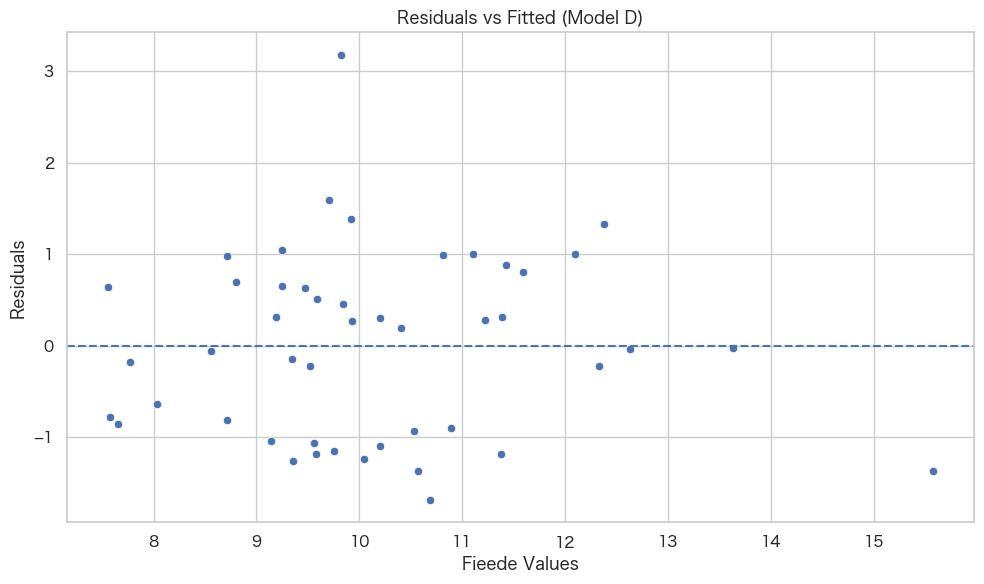

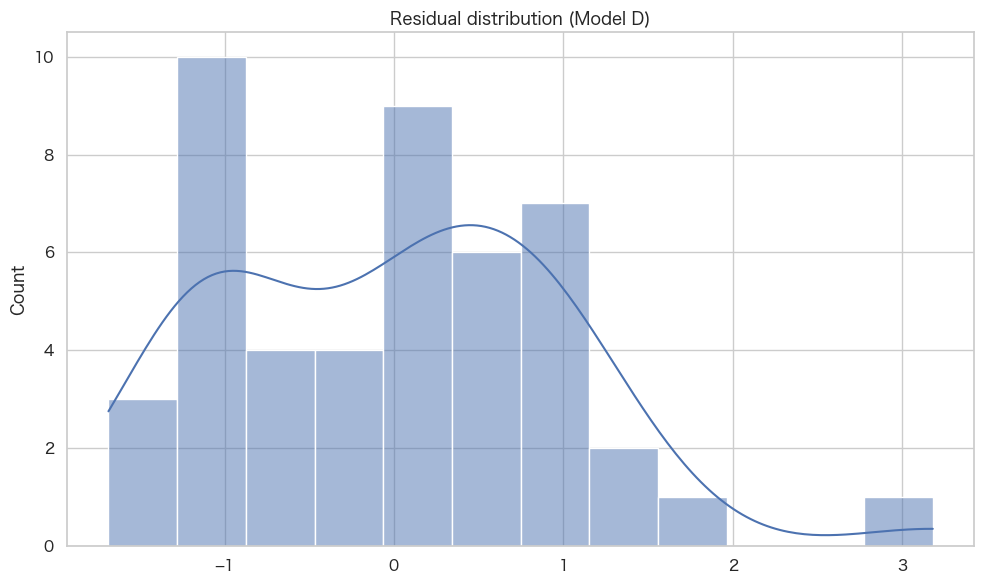

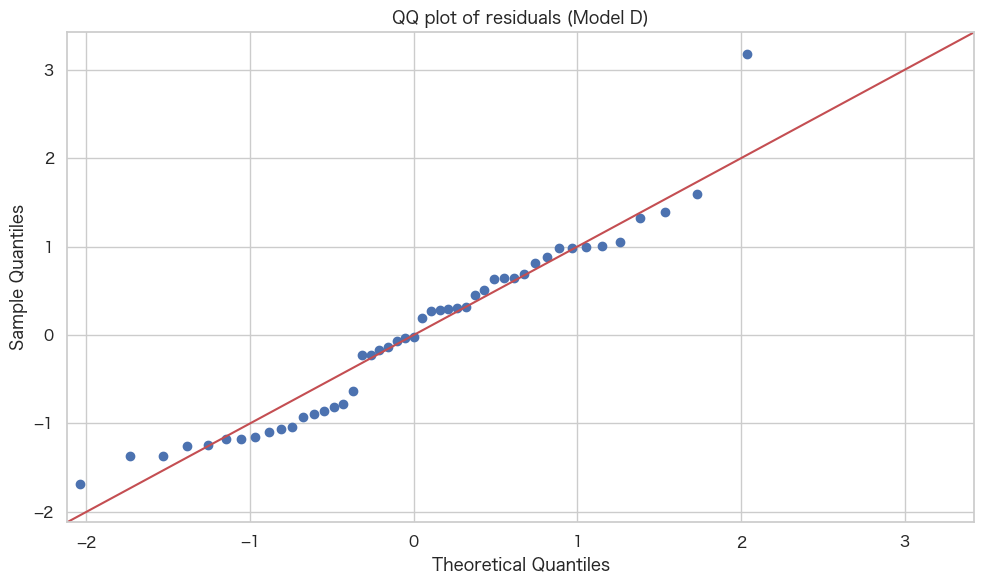

In [10]:
# ---------------------------------------------------------
# 6. 残差診断（Model D）
# ---------------------------------------------------------

# 評価フェーズで選定された「最良モデル」のインスタンスを取得
m = fitted["Model_D"]

# モデルによる「推論値（予測値：Fitted Values）」を抽出し、分析用ベクトルとして保持
pred = m.fittedvalues

# 実測値と予測値の乖離である「残差（Residuals）」を取得し、モデルが捉えきれなかった誤差成分を特定
resid = m.resid

# --- 診断1：等分散性の確認（Residuals vs Fitted） ---
# 残差に「何らかのパターン（未学習の法則）」が残っていないかを確認するためのキャンバスを用意
plt.figure()

# X軸に予測値、Y軸に残差をプロットし、誤差の発生がランダムであるか（＝モデルが情報を搾り取れているか）を可視化
sns.scatterplot(x=pred,y=resid)

# 残差ゼロ（完全正解）の基準線を破線で引き、バイアスの偏りを視認しやすくする
plt.axhline(0,linestyle="--")

# チャートの意図を明確にするメタデータ（タイトル・軸ラベル）を定義
plt.title("Residuals vs Fitted (Model D)")
plt.xlabel("Fieede Values")
plt.ylabel("Residuals")

# 要素の配置を最適化し、レポート出力時の視認性を担保
plt.tight_layout()
plt.show()

# --- 診断2：残差の正規性の確認（Histogram） ---
# 誤差の分布形状を確認するためのキャンバスを初期化
plt.figure()

sns.histplot(resid,kde=True,bins=12,edgecolor="white")

plt.title("Residual distribution (Model D)")
plt.tight_layout()
plt.show()

# --- 診断3：理論分布との適合度確認（QQ Plot） ---
# 観測された残差が、理論上の正規分布とどれほど一致するかを「Q-Qプロット」で厳密に検定
# 45度線（line="45"）上にプロットが乗れば、残差は理想的な正規分布に従っていると判断可能
sm.qqplot(resid,line="45")

plt.title("QQ plot of residuals (Model D)")
plt.tight_layout()
plt.show()

,row_index,cooks_distance
0,12,0.894673
1,45,0.187735
2,2,0.081850
3,38,0.061776
4,41,0.051300
5,31,0.046894
6,26,0.043950
7,17,0.041867
8,8,0.040334
9,5,0.031996


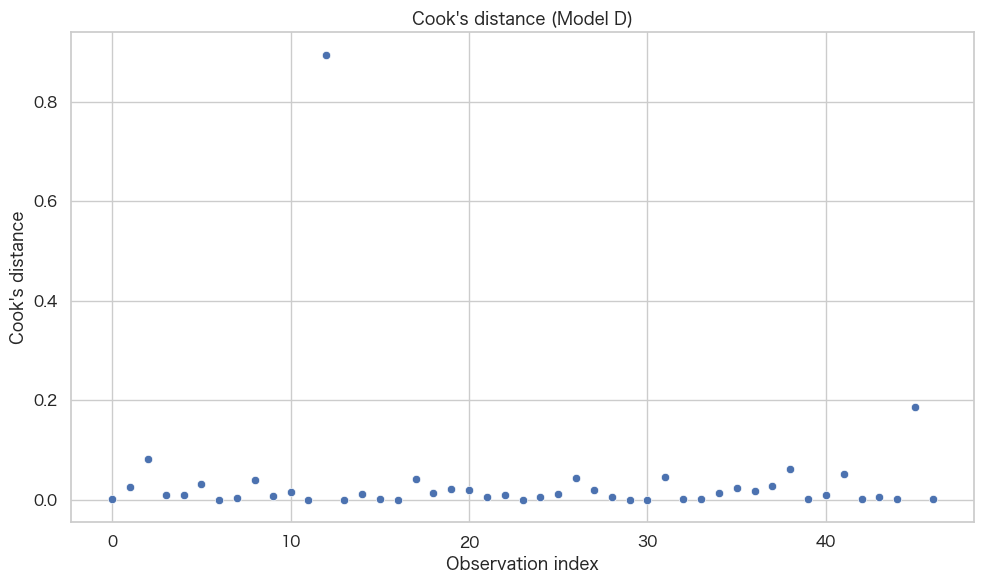

In [11]:
# ---------------------------------------------------------
# 7. 影響点の確認（Cook's distance）
# ---------------------------------------------------------

# モデルの推論結果に対し、各データ点がパラメータ推定に与える「影響度（Influence）」を包括的に計算
influence = m.get_influence()

# 観測値の削除が回帰係数全体に及ぼす変化量を定量化した指標「クックの距離（Cook's Distance）」を抽出
cooks = influence.cooks_distance[0]

# 影響力が突出している「外れ値候補（Outliers）」として抽出する上位N件の閾値を設定
top_k = 10

# クックの距離を降順ソートし、モデルを歪めている可能性が最も高いレコードのインデックスを取得
idx = np.argsort(cooks)[::-1][:top_k]

# 特定された高影響点（High Leverage Points）を特定名（都道府県名など）と紐付けるためのレポート用DFを構築
impact_df = pd.DataFrame({
    "row_index": data.index[idx],
    "cooks_distance": cooks[idx]
}).reset_index(drop=True)

# 優先的にドリルダウン（深掘り調査）すべき「モデルを歪ませている犯人候補」のリストを出力
display(impact_df)

# --- 参考：プロットによる視覚的診断 ---
plt.figure()

# 横軸にデータ番号、縦軸にクックの距離をとり、突出したスパイク（異常値）がないか可視化
sns.scatterplot(x=np.arange(len(cooks)),y=cooks)

plt.title("Cook's distance (Model D)")
plt.xlabel("Observation index")
plt.ylabel("Cook's distance")
plt.tight_layout()
plt.show()

In [12]:
# ---------------------------------------------------------
# 8. LOOCVで汎化性能を比較（修正版：cross_val_predict使用）
# ---------------------------------------------------------

# 交差検証（CV）の過程で「テストデータに対する予測値」だけを収集する専用関数をインポート
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score

# サンプルサイズが極少（n=47）のため、1件抜き交差検証（LOO）を採用して学習データを最大化
loo = LeaveOneOut()

# エラー回避のため、「スコアの平均」ではなく「予測値の集約」で評価するロジックに変更
def loocv_r2_fix(data: pd.DataFrame, y: str, x_cols: list[str]) -> float:
    # scikit-learnの計算効率を高めるため、データフレームからNumpy配列（数値行列）へ変換
    X = data[x_cols].values
    yv = data[y].values
    
    # 検証用のアルゴリズムとして、解釈性が高く過学習しにくい線形回帰を指定
    lr = LinearRegression()
    
    # 各サンプルに対し「自分以外の全データで学習したモデル」を使って予測（Out-of-Fold予測）を実行
    # これにより、47回分のループ処理を内部で行い、全員分の「カンニングなしの予測値」を一括取得
    preds = cross_val_predict(lr, X, yv, cv=loo)
    
    # 全員分の「予測値」と「実測値」が揃った状態でR2を計算するため、定義不能（NaN）エラーを回避
    return float(r2_score(yv, preds))

# モデルごとのベンチマーク結果を蓄積するリストを初期化
cv_rows = []

# 定義済みのモデル候補（Model A/B/C/D）を順次実行し、汎化性能を測定するトーナメントを開始
for name, x_cols in models.items():
    cv_rows.append({
        "model": name,                                      # モデルの識別子
        "loocv_r2": loocv_r2_fix(data, target, x_cols), # LOO検証で算出された「真の精度（汎化性能）」
        "features": ", ".join(x_cols)                       # 使用した特徴量の構成
    })

# 汎化性能が高い順（R2スコアの降順）にソートし、採用すべき「チャンピオンモデル」を決定
cv_df = pd.DataFrame(cv_rows).sort_values("loocv_r2", ascending=False)
display(cv_df)

,model,loocv_r2,features
3,Model_D,0.632566,"rent_private, night_shift_72h_plus, job_openin..."
2,Model_C,0.613436,"rent_private, home_ownership_rate, night_shift..."
1,Model_B,0.485888,"rent_private, home_ownership_rate, night_shift..."
0,Model_A,0.469047,"rent_private, home_ownership_rate"


In [13]:
# ---------------------------------------------------------
# 9. モデル比較まとめ（GitHubで一目で分かる）
# ---------------------------------------------------------

# summary_df を最新の results（Model_Dを含む）から再作成
summary_df = pd.DataFrame(results)

# 「学習データでの説明力（In-Sample）」と「未知データへの汎化性能（Out-of-Sample）」を内部結合し、モデル評価の完全な一覧表を作成
final = summary_df.merge(cv_df[["model","loocv_r2"]], on="model", how="left")

# 「汎化性能（LOOCV）」を最優先、同点時は「説明力（Adj R2）」を第2基準としてランク付けし、最終的なチャンピオンモデルを確定・表示
display(final.sort_values(["loocv_r2","adj_r2"],ascending=False))

,model,n,adj_r2,aic,bic,rmse_in_sample,features,loocv_r2
3,Model_D,47,0.693679,141.310485,148.711076,0.999258,"rent_private,night_shift_72h_plus,job_openings...",0.632566
2,Model_C,47,0.692066,142.451318,151.702056,0.990167,"rent_private,home_ownership_rate,night_shift_7...",0.613436
1,Model_B,47,0.608368,152.857758,160.258349,1.129869,"rent_private,home_ownership_rate,night_shift_7...",0.485888
0,Model_A,47,0.567509,156.602491,162.152934,1.201073,"rent_private,home_ownership_rate",0.469047


In [14]:
# ---------------------------------------------------------
# 10. 最終モデルの採用（結論だけ明示）
# ---------------------------------------------------------

# 「汎化性能（LOOCV）」を最優先、次点で「説明力（Adj R2）」を評価し、客観的指標に基づき「チャンピオンモデル」をプログラム的に選定
best_model = final.sort_values(["loocv_r2","adj_r2"], ascending=False).iloc[0]["model"]

# 分析パイプラインの最終結論（Decision）として、採用されたモデル名をログに出力
print("Selected model:", best_model)

# そのモデルを構成する「特徴量セット」を表示し、今後の運用フェーズで監視すべき変数を確定
print("Features:", models[best_model])

Selected model: Model_D
Features: ['rent_private', 'night_shift_72h_plus', 'job_openings_ratio']


---

## ✅ Model Selection Summary（結論）

本Notebookでは、候補モデルの比較（説明力・汎化性能）と診断（共線性・残差・影響点）を通じて、最終モデル（Champion Model）を選定した。  
以降の解釈・提言は `05_interpretation.ipynb`、構造分解（新卒/既卒）は `06_subgroup_analysis.ipynb` にて扱う。

---

## ⚠ Limitations（現時点の制約）

- 都道府県単位の集計データであり、個人レベルの因果関係は示せない  
- サンプル数が47であり、係数の安定性には限界がある（LOOCVで過大評価を抑制）  
- 指標の年次差・定義差（測定誤差）や未観測要因の影響を受けうる  

---

## 🚀 Next（発展：データエンジニア視点）

- `data/processed/nurse_data_clean.csv` 生成までをETL化し、再現性・監査性を担保  
- Feature Layer（特徴量層）を分離し、モデリングの再利用性を向上  
- データ品質チェック（欠損・範囲・分布ドリフト）を定期実行できる形へ拡張  
